## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [450]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [451]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_select' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (60, 6)


serum table has 36 samples and 1071 metabolites

In [452]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)


In [453]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != 'DEG']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != 'DEG']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS != 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 47) 
 (24, 60)


In [454]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [455]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 0 rows in serum file and 0 in muscle


In [456]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))

samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
samples_2HB = serum_samples[serum_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
serum_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_na['Tx'] = serum_na.Group.str[0]
serum_na['Ex'] = serum_na.Group.str[1]



In [457]:
# impute based on group values

def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).min())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Tx')
serum_na = impute_by_group(serum_na,'Tx')


In [458]:
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns = df.select_dtypes(include=object)
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.drop(object_columns.columns,axis=1).fillna(df.min(axis=0))

    if scale_by == 1:
        df = df.div(df.min())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
        df = pd.merge(left=df,right=object_columns,how='left',left_index=True,right_index=True) # add back object columns
    return df



In [459]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,1,1)
serum_med = met_transform(serum_na,1,1,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [460]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method

    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns1 = df1.select_dtypes(include=object)
    object_columns2 = df2.select_dtypes(include=object)
    df1 = df1.drop(object_columns1.columns,axis=1)
    df2 = df2.drop(object_columns2.columns,axis=1)

    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    # object columns are the same between the two, since we are just testing different normalization methods, so only add back one of the object columns
    df_fwn = pd.merge(left = df_fwn, right = object_columns1, how='left',left_index=True,right_index=True) # add back object columns
    return df_fwn


In [461]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.723404255319149 
 The proportion of normally distributed columns with method_2 is: 0.723404255319149
take 47 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.6166666666666667 
 The proportion of normally distributed columns with method_2 is: 0.6166666666666667
take 60 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [462]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [463]:
# add VO2 columns matching by index
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,dihydroxyacetonephosphateDHAP,fumarate,isoleucine,...,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-1.826174,-0.279133,-0.635140,1.521123,1.706764,-0.076182,-0.137823,-0.155031,1.368142,1.060958,...,-0.617765,1.329606,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-0.543263,-1.383228,0.858479,-0.138596,0.960910,-0.731189,-1.742482,-0.525476,0.478742,1.147506,...,-0.687829,0.007866,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
VR60,0.489360,-1.107481,1.899008,-0.374624,0.206269,-0.334345,-0.995647,0.466238,0.526490,-0.697483,...,0.473637,-0.543103,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VS61,-0.901171,-0.811796,-1.864527,-0.577633,1.046403,-1.077269,-0.592166,-0.672953,-0.067501,0.645919,...,-1.095686,0.043469,VS,V,S,-0.818041,-0.904624,-0.845068,-1.701249,-1.707959
VR83,2.011026,1.215761,1.403708,-1.243140,0.602417,-0.514258,1.188630,0.551877,-0.490731,-0.656866,...,0.831951,0.414610,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155


In [464]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,glucosephosphate,dihydroxyacetonephosphateDHAP,fumarate,...,dihydroxymethylbutyrate,isocaproylcarnitine,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,1.183489,-0.009661,-0.207900,1.059161,0.023355,0.236337,-1.260088,0.680033,1.519812,1.266707,...,0.149920,0.185624,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-1.624494,-1.667780,-2.147919,2.133900,-0.008502,-2.296331,-1.804767,2.159333,0.616458,-0.113812,...,-1.190974,-1.452231,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
VR42,1.252783,1.718783,0.133138,0.175097,0.421604,-0.624476,1.093364,-1.054361,0.066878,-0.050595,...,0.167658,-1.452231,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
VS43,-0.030274,-0.544443,-1.015259,-0.814235,0.665148,0.840618,-0.661984,-0.215343,-0.417168,-0.890063,...,0.377880,0.205554,VS,V,S,-0.818041,-0.904624,-0.845068,-1.388309,-1.337112
VR60,1.230285,0.081521,-0.229038,0.437224,0.579304,0.235686,-0.896080,0.343548,0.867403,0.028739,...,0.140492,1.043112,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418


In [465]:
# conduct basic differential abundance analysis
import scipy.stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from pingouin import ancova

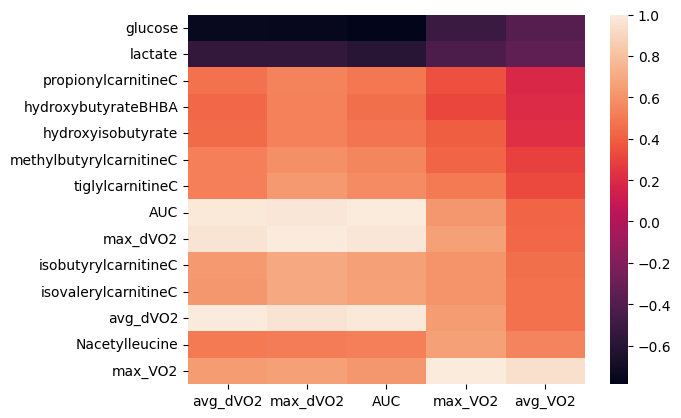

In [466]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

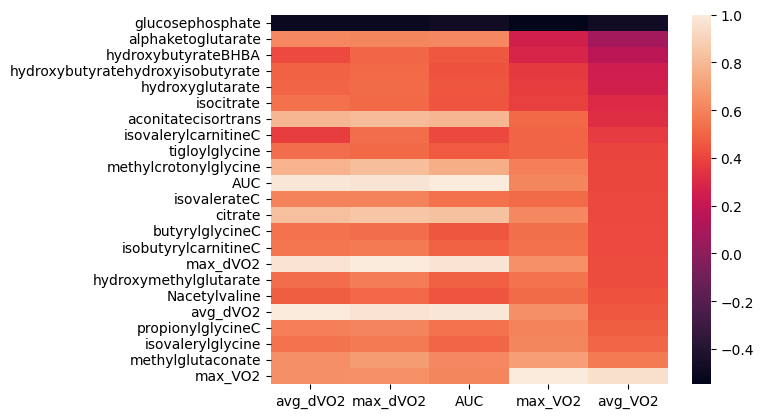

In [467]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

In [513]:
results = pd.DataFrame(columns=['Metabolite','p_value','AIC'])
ancova_fwn = pd.merge(left=serum_fwn,
                      right=muscle_fwn[['hydroxybutyratehydroxyisobutyrate','glucose']].add_suffix('_mus'),how='left',left_index=True,right_index=True,)
# ancova_fwn = ancova_fwn[ancova_fwn.Ex == 'R']
covars=['hydroxybutyratehydroxyisobutyrate_mus','glucose_mus','avg_VO2','max_dVO2']
for met in ancova_fwn.columns[:-10]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Group')
    model = sm.OLS(ancova_fwn[met],ancova_fwn[covars]).fit()
    aic = model.aic
    results.loc[len(results)] = pd.Series({
        'Metabolite':met,
        'p_value':ancova_table.iloc[0,4],
        'AIC':aic

    })

In [510]:
results = pd.DataFrame(columns=['Metabolite','p_value','AIC'])
ancova_fwn = pd.merge(left=muscle_fwn,
                      right=serum_fwn[['glucosephosphate','carnitine']].add_suffix('_ser'),how='left',left_index=True,right_index=True,)
# ancova_fwn = ancova_fwn[ancova_fwn.Ex == 'R']
covars=['glucosephosphate_ser','carnitine_ser','avg_VO2','avg_dVO2']
for met in ancova_fwn.columns[:-10]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Tx')
    model = sm.OLS(ancova_fwn[met],ancova_fwn[covars]).fit()
    aic = model.aic
    results.loc[len(results)] = pd.Series({
        'Metabolite':met,
        'p_value':ancova_table.iloc[0,4],
        'AIC':aic

    })

In [514]:
results[results.p_value < 0.3].sort_values(by='p_value').reset_index()

,index,Metabolite,p_value,AIC
0,44,aconitatecisortrans,0.00016,49.329891
1,53,deoxycarnitine,0.000175,67.648607
2,32,acetylcarnitineC,0.000399,66.825173
3,37,propionylglycineC,0.001164,60.832074
4,31,isovalerateC,0.001176,62.410005
5,55,hydroxyglutarate,0.001265,66.715827
6,51,betahydroxyisovaleroylcarnitine,0.001281,68.454596
7,15,lactate,0.003547,58.886583
8,0,alphaketoglutarate,0.004399,60.163014
9,41,hydroxyethylpropionate,0.007231,71.382252


In [515]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
results[results.reject == True]

reject
False    45
True     15
Name: count, dtype: int64


,Metabolite,p_value,AIC,adj_p,reject
0,alphaketoglutarate,0.004399,60.163014,0.029325,True
5,succinate,0.015059,68.203562,0.064538,True
12,malate,0.023173,74.771648,0.092692,True
15,lactate,0.003547,58.886583,0.026601,True
22,citrate,0.009204,44.772354,0.042479,True
31,isovalerateC,0.001176,62.410005,0.010982,True
32,acetylcarnitineC,0.000399,66.825173,0.007990,True
37,propionylglycineC,0.001164,60.832074,0.010982,True
40,propionylcarnitineC,0.008364,66.245922,0.041818,True
41,hydroxyethylpropionate,0.007231,71.382252,0.041818,True


### OLD section

In [931]:
grouped = muscle_fwn.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite', 'VS_mean', 'VR_mean', 'HS_mean', 'HR_mean','VS_var','VR_var','HS_var','HR_var', 'p_value']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_fwn.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform anova
    test_stat, p_value = ttest_ind(VR, HR)
    # get group means
    VS_mean = VS.mean()
    VR_mean = VR.mean()
    HS_mean = HS.mean()
    HR_mean = HR.mean()
    VS_var = VS.var()
    VR_var = VR.var()
    HS_var = HS.var()
    HR_var = HR.var()
    VR_HR = VR_mean - HR_mean
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'VS_mean': VS_mean,
                              'VR_mean': VR_mean,
                              'HS_mean': HS_mean,
                              'HR_mean': HR_mean,
                              'VS_var': VS_var,
                              'VR_var': VR_var,
                              'HS_var': HS_var,
                              'HR_var': HR_var,
                              'p_value': p_value})



In [2813]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject


(array([6., 6., 4., 4., 8., 4., 4., 1., 4., 5.]),
 array([0.07273492, 0.16539239, 0.25804987, 0.35070735, 0.44336483,
        0.5360223 , 0.62867978, 0.72133726, 0.81399474, 0.90665221,
        0.99930969]),
 <BarContainer object of 10 artists>)

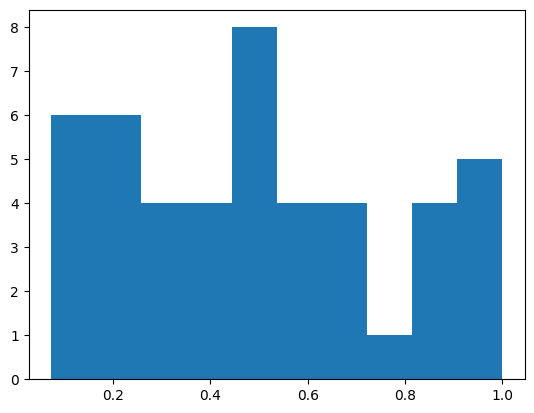

In [2814]:
plt.hist(results.p_value)

In [2815]:
results.reject.value_counts()

reject
False    46
Name: count, dtype: int64

### Attempting Two-Way ANOVA
Really just want an indication that there is an interaction between 2HB and exercise in modifying some of the metabolites

In [2820]:
results = pd.DataFrame(columns=['Metabolite', 'ME_Tx', 'ME_Ex', 'Interaction']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in df_fwn_scale.columns[:-3]:
    #create model and perform anova
    model = ols(f'{met} ~ C(Tx) + C(Ex) + C(Tx):C(Ex)', data=df_fwn_scale).fit()
    result = sm.stats.anova_lm(model, type=2)

    # main effect and interaction
    ME_Tx = result.iloc[0,4]
    ME_Ex = result.iloc[1,4]
    Interaction = result.iloc[1,4]
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'ME_Tx': ME_Tx,
                              'ME_Ex': ME_Ex,
                              'Interaction': Interaction})



reject
False    33
True     13
Name: count, dtype: int64


(array([13.,  6.,  3.,  4.,  0.,  2.,  0.,  6.,  4.,  8.]),
 array([0.00152436, 0.09999203, 0.19845971, 0.29692738, 0.39539505,
        0.49386273, 0.5923304 , 0.69079808, 0.78926575, 0.88773343,
        0.9862011 ]),
 <BarContainer object of 10 artists>)

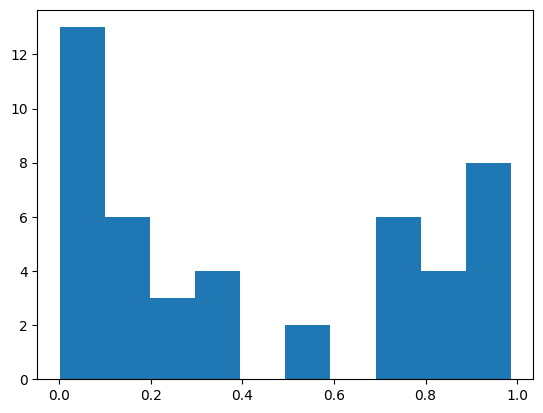

In [2821]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.Interaction.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
plt.hist(results.adj_p)